In [1]:
from gekko import GEKKO 
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

In [2]:
def sir_time_dependant(t, z, beta, gamma):
    s, i = z
    return [-beta*s*i, beta*s*i -gamma*i]

In [10]:
def sir_constant(nf,nt,beta,gamma,u1max,u2max,b,c):
    m = GEKKO(remote=False)  # create GEKKO model
    n_f=nf
    n_t=nt  
    time = np.linspace(0,nf,nt) # time points
    m.time =time 

    b=b
    c=c

    i0=0.01
    s0=1-i0

    beta=beta
    s = m.Var(s0,lb=0,ub=1) 
    i = m.Var(i0,lb=0,ub=1) # create GEKKO variables
    j = m.Var(s0-1)
    u1 = m.Param(u1max/2)
    u2 = m.Param(u2max/2)
 
    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)

    # create GEKKO equations
    m.Equation(s.dt() == -(beta+u2)*s*i - u1*s)
    m.Equation(i.dt() == (beta+u2)*s*i+u1*s-gamma*i)
    m.Equation(j.dt() == b*u1**2 + c*u2**2)

    m.Obj(s*final+j*final)



    m.options.IMODE = 6
    #m.options.NODES = 4
    m.solve(disp=False)
    return s.value,i.value,u1.value,u2.value,(s.value[-1]-1+j.value[-1])

def sir_optimal(nf,nt,beta,gamma,u1max,u2max,b,c):
    m = GEKKO(remote=False)  # create GEKKO model
    n_f=nf
    n_t=nt  
    time = np.linspace(0,nf,nt) # time points
    m.time =time 

    b=b
    c=c

    i0=0.01
    s0=1-i0

    beta=beta
    s = m.Var(s0,lb=0,ub=1) 
    i = m.Var(i0,lb=0,ub=1) # create GEKKO variables
    j = m.Var(s0-1)
    u1= m.Var(u1max, lb=0 , ub=u1max)
    u2 = m.Var(0 , lb=0 , ub=u2max)
 
    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)

    # create GEKKO equations
    m.Equation(s.dt() == -(beta+u2)*s*i - u1*s)
    m.Equation(i.dt() == (beta+u2)*s*i+u1*s-gamma*i)
    m.Equation(j.dt() == b*u1**2 + c*u2**2)

    m.Obj(s*final+j*final)



    m.options.IMODE = 6
    #m.options.NODES = 4
    m.solve(disp=False)
    return s.value,i.value,u1.value,u2.value,(s.value[-1]-1+j.value[-1])

def sir_heuristic(nf,nt,beta,gamma,u1max,u2max,s_func,i_func,b,c):
    m = GEKKO(remote=False)  # create GEKKO model
    n_f=nf
    n_t=nt  
    time = np.linspace(0,nf,nt) # time points
    m.time =time 

    b=b
    c=c

    i0=0.01
    s0=1-i0

    beta=beta
    s = m.Var(s0,lb=0,ub=1) 
    i = m.Var(i0,lb=0,ub=1) # create GEKKO variables
    j = m.Var(s0-1)
    u1 = m.Param(u1max*s_func)
    u2 = m.Param(u2max*s_func*(i_func))
 
    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)

    # create GEKKO equations
    m.Equation(s.dt() == -(beta+u2)*s*i - u1*s)
    m.Equation(i.dt() == (beta+u2)*s*i+u1*s-gamma*i)
    m.Equation(j.dt() == b*u1**2 + c*u2**2)

    m.Obj(s*final+j*final)



    m.options.IMODE = 6
    #m.options.NODES = 4
    m.solve(disp=False)
    return s.value,i.value,u1.value,u2.value,(s.value[-1]-1+j.value[-1])

function_dict={'opt':sir_optimal,'hero':sir_heuristic,'const':sir_constant}

In [11]:
%%time
tf=5
n=500
time=np.linspace(0,tf,n)
gamma=0.1
beta=1
u1_max=0.06
u2_max=0.3
b=15
c=1
sol = solve_ivp(sir_time_dependant, [0, tf],[0.99, 0.01],t_eval=time,args=(beta,gamma),
                dense_output=True)
s_opt,i_opt,u1_opt,u2_opt,_=function_dict['opt'](tf,n,beta,gamma,u1_max,u2_max,b,c)
s_hero,i_hero,u1_hero,u2_hero,_=function_dict['hero'](tf,n,beta,gamma,u1_max,u2_max,sol.y[0],sol.y[1],b,c)
s_const,i_const,u1_const,u2_const,_=function_dict['const'](tf,n,beta,gamma,u1_max,u2_max,b,c)

Wall time: 6.54 s


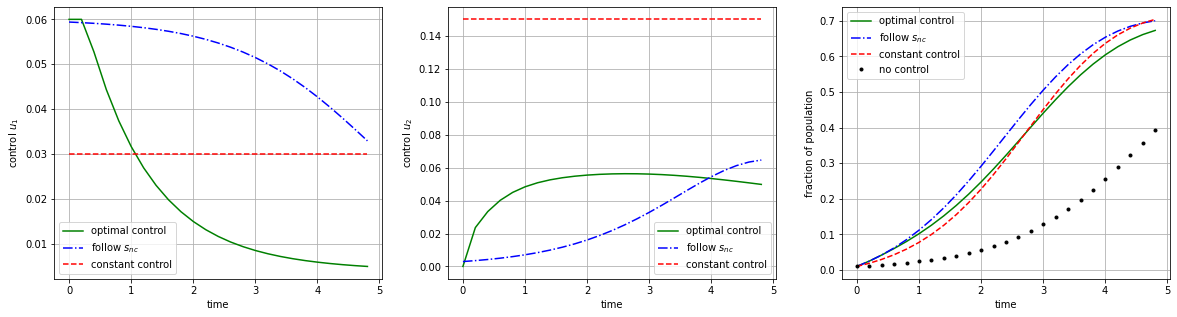

In [14]:
i_s=[i_opt,i_hero,i_const,sol.y[1]]
u1_s=[u1_opt,u1_hero,u1_const]
u2_s=[u2_opt,u2_hero,u2_const]
colors=['g','blue','red','k']
shapes=['-','-.','--','.']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=20
fig,ax=plt.subplots(1,3,figsize=(20,5))
for i in range(3):
    ax[0].plot(time[::ns],u1_s[i][::ns],shapes[i],color=colors[i],label=labels[i])
    ax[1].plot(time[::ns],u2_s[i][::ns],shapes[i],color=colors[i],label=labels[i])
ax[0].grid()
ax[0].set_xlabel('time')
ax[0].set_ylabel('control $u_1$')
ax[0].legend()

ax[1].grid()
ax[1].set_xlabel('time')
ax[1].set_ylabel('control $u_2$')
ax[1].legend()

for i in range(4):
    ax[2].plot(time[::ns],i_s[i][::ns],shapes[i],color=colors[i],label=labels[i])

ax[2].grid()
ax[2].set_xlabel('time')
ax[2].set_ylabel('fraction of population')
ax[2].legend()

## varying beta 

In [18]:
%%time
tf=5
n=500
time=np.linspace(0,tf,n)
gamma=0.1
beta_list=np.linspace(0,2,20)
u1_max=0.06
u2_max=0.3
b=15
c=1

j_opt=np.zeros(len(beta_list))
j_hero=np.zeros(len(beta_list))
j_const=np.zeros(len(beta_list))
j_no=np.zeros(len(beta_list))

for index,beta in enumerate(beta_list):
    print('\r',index,end="")
    sol = solve_ivp(sir_time_dependant, [0, tf],[0.99, 0.01],t_eval=time,args=(beta,gamma),
                dense_output=True)
    s_opt,i_opt,u1_opt,u2_opt,j_opt[index]=function_dict['opt'](tf,n,beta,gamma,u1_max,u2_max,b,c)
    s_hero,i_hero,u1_hero,u2_hero,j_hero[index]=function_dict['hero'](tf,n,float(beta),gamma,u1_max,u2_max,sol.y[0],sol.y[1],b,c)
    s_const,i_const,u1_const,u2_const,j_const[index]=function_dict['const'](tf,n,beta,gamma,u1_max,u2_max,b,c)
    j_no[index]=-1+sol.y[0][-1]


 19Wall time: 2min 45s


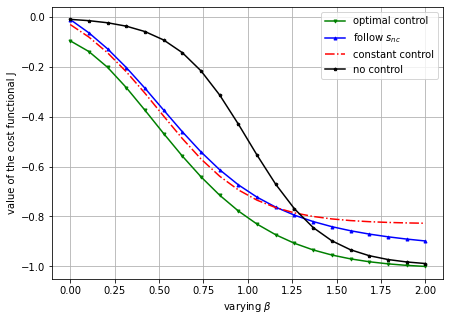

In [19]:
j_s=[j_opt,j_hero,j_const,j_no]

colors=['g','blue','red','k']
shapes=['-v','-^','-.','-p']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=1
fig,ax=plt.subplots(1,1,figsize=(7,5))

for i in range(4):
    ax.plot(beta_list[::ns],j_s[i][::ns],shapes[i],color=colors[i],label=labels[i],ms=3)

ax.grid()
ax.set_xlabel('varying $\\beta$')
ax.set_ylabel('value of the cost functional J')
ax.legend()

## varying gamma 

In [20]:
%%time
tf=5
n=500
time=np.linspace(0,tf,n)
gamma_list=np.linspace(0,2,20)
beta=1
u1_max=0.06
u2_max=0.3
b=15
c=1

j_opt=np.zeros(len(gamma_list))
j_hero=np.zeros(len(gamma_list))
j_const=np.zeros(len(gamma_list))
j_no=np.zeros(len(gamma_list))

for index,gamma in enumerate(gamma_list):
    print('\r',index,end="")
    sol = solve_ivp(sir_time_dependant, [0, tf],[0.99, 0.01],t_eval=time,args=(beta,gamma),
                dense_output=True)
    s_opt,i_opt,u1_opt,u2_opt,j_opt[index]=function_dict['opt'](tf,n,beta,gamma,u1_max,u2_max,b,c)
    s_hero,i_hero,u1_hero,u2_hero,j_hero[index]=function_dict['hero'](tf,n,float(beta),gamma,u1_max,u2_max,sol.y[0],sol.y[1],b,c)
    s_const,i_const,u1_const,u2_const,j_const[index]=function_dict['const'](tf,n,beta,gamma,u1_max,u2_max,b,c)
    j_no[index]=-1+sol.y[0][-1]


 19Wall time: 1min 24s


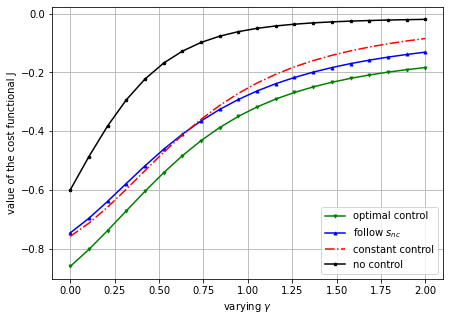

In [21]:
j_s=[j_opt,j_hero,j_const,j_no]

colors=['g','blue','red','k']
shapes=['-v','-^','-.','-p']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=1
fig,ax=plt.subplots(1,1,figsize=(7,5))

for i in range(4):
    ax.plot(gamma_list[::ns],j_s[i][::ns],shapes[i],color=colors[i],label=labels[i],ms=3)

ax.grid()
ax.set_xlabel('varying $\\gamma$')
ax.set_ylabel('value of the cost functional J')
ax.legend()

## varying T

In [22]:
%%time
tf_list=np.linspace(1,10,20)
n=500

gamma = 0.1
beta=1
u1_max=0.06
u2_max=0.3
b=15
c=1

j_opt=np.zeros(len(tf_list))
j_hero=np.zeros(len(tf_list))
j_const=np.zeros(len(tf_list))
j_no=np.zeros(len(tf_list))

for index,tf in enumerate(tf_list):
    time=np.linspace(0,tf,n)
    print('\r',index,end="")
    sol = solve_ivp(sir_time_dependant, [0, tf],[0.99, 0.01],t_eval=time,args=(beta,gamma),
                dense_output=True)
    s_opt,i_opt,u1_opt,u2_opt,j_opt[index]=function_dict['opt'](tf,n,beta,gamma,u1_max,u2_max,b,c)
    s_hero,i_hero,u1_hero,u2_hero,j_hero[index]=function_dict['hero'](tf,n,float(beta),gamma,u1_max,u2_max,sol.y[0],sol.y[1],b,c)
    s_const,i_const,u1_const,u2_const,j_const[index]=function_dict['const'](tf,n,beta,gamma,u1_max,u2_max,b,c)
    j_no[index]=-1+sol.y[0][-1]


 19Wall time: 2min 28s


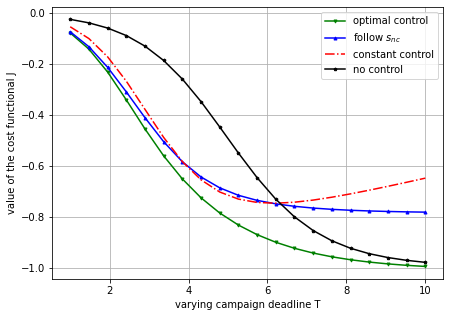

In [23]:
j_s=[j_opt,j_hero,j_const,j_no]

colors=['g','blue','red','k']
shapes=['-v','-^','-.','-p']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=1
fig,ax=plt.subplots(1,1,figsize=(7,5))

for i in range(4):
    ax.plot(tf_list[::ns],j_s[i][::ns],shapes[i],color=colors[i],label=labels[i],ms=3)

ax.grid()
ax.set_xlabel('varying campaign deadline T')
ax.set_ylabel('value of the cost functional J')
ax.legend()

## varying b

In [24]:
%%time
tf=5
n=500

gamma = 0.1
beta=1
u1_max=0.06
u2_max=0.3
b_list=np.linspace(10,30,20)
c=1

j_opt=np.zeros(len(b_list))
j_hero=np.zeros(len(b_list))
j_const=np.zeros(len(b_list))
j_no=np.zeros(len(b_list))

for index,b in enumerate(b_list):
    time=np.linspace(0,tf,n)
    print('\r',index,end="")
    sol = solve_ivp(sir_time_dependant, [0, tf],[0.99, 0.01],t_eval=time,args=(beta,gamma),
                dense_output=True)
    s_opt,i_opt,u1_opt,u2_opt,j_opt[index]=function_dict['opt'](tf,n,beta,gamma,u1_max,u2_max,b,c)
    s_hero,i_hero,u1_hero,u2_hero,j_hero[index]=function_dict['hero'](tf,n,float(beta),gamma,u1_max,u2_max,sol.y[0],sol.y[1],b,c)
    s_const,i_const,u1_const,u2_const,j_const[index]=function_dict['const'](tf,n,beta,gamma,u1_max,u2_max,b,c)
    j_no[index]=-1+sol.y[0][-1]


 0

NameError: name 'TimeoutExpired' is not defined

In [ ]:
j_s=[j_opt,j_hero,j_const,j_no]

colors=['g','blue','red','k']
shapes=['-v','-^','-.','-p']
labels=['optimal control','follow $s_{nc}$','constant control','no control']
ns=1
fig,ax=plt.subplots(1,1,figsize=(7,5))

for i in range(4):
    ax.plot(b_list[::ns],j_s[i][::ns],shapes[i],color=colors[i],label=labels[i],ms=3)

ax.grid()
ax.set_xlabel('varying weight parameter b')
ax.set_ylabel('value of the cost functional J')
ax.legend()